In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# get stock data of 1 stock
def get_stock_data_yahoo(ticker,start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    return data

In [3]:
# define your strategy
def SMAMeanReversionSafety(data, sma, threshold, safety_threshold=0.25, shorts=False):
    
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(
        (data['extension']<-threshold) & 
        (data['extension']>-safety_threshold), 
        1, data['position'])
    
    if shorts:
        data['position'] = np.where(
            (data['extension']>threshold) & 
            (data['extension']<safety_threshold),
            -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01, 0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()

In [8]:
#Risk and return function
def get_risk_return_Stats(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate)/ sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (buy_hold_strat['annual_returns'] - risk_free_rate)/ buy_hold_strat['annual_volatility']
    
    stats_dict = {'strat_stats': sma_strat,
                  'base_stats': buy_hold_strat}
    stats_df = pd.DataFrame(stats_dict).round(3)
    
    return stats_df

In [11]:
# Define plot functions
def SMA_plot(data,SMA):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(3, figsize=(10, 8), sharex=True)
    long = data.loc[data['position']==1]['Close']
    ax[0].plot(data['Close'], label='Price', linestyle=':', color=colors[1])
    ax[0].plot(data['SMA'], label='SMA', linestyle='--', color=colors[0])
    ax[0].scatter(long.index, long, label='Long', c=colors[2])
    ax[0].legend(bbox_to_anchor=[1, 0.75])
    ax[0].set_ylabel('Price ($)')
    ax[0].set_title(f'{ticker} Price and Positions with {SMA}-Day Moving Average')
    ax[1].plot(data['extension']*100, label='Extension', color=colors[0])
    ax[1].axhline(threshold*100, linestyle='--', color=colors[1])
    ax[1].axhline(-threshold*100, label='Threshold', linestyle='--', color=colors[1])
    ax[1].axhline(0, label='Neutral', linestyle=':', color='k')
    ax[1].set_title('Price Extension and Buy/Sell Thresholds')
    ax[1].set_ylabel(f'Extension (%)')
    ax[1].legend(bbox_to_anchor=[1, 0.75])
    ax[2].plot(data['position'])
    ax[2].set_xlabel('Date')
    ax[2].set_title('Position')
    ax[2].set_yticks([-1, 0, 1])
    ax[2].set_yticklabels(['Short', 'Neutral', 'Long'])
    plt.tight_layout()
    return plt.show()

In [16]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-05-17'
apple = get_stock_data_yahoo(ticker, start_date, end_date)

In [17]:
sma_list = []
for sma in (30,50,70,100,120):
    data =  SMAMeanReversionSafety(apple, sma, threshold = 0.1 ,safety_threshold = 0.2)
    df_stats = get_risk_return_Stats(data)
    strat_stats = df_stats['strat_stats']
    sma_case = {'sma': sma,
               'tot_returns': strat_stats['tot_returns'],
               'annual_returns':strat_stats['annual_returns'],
               'annual_volatility': strat_stats['annual_volatility'],
               'sharpe_ratio': strat_stats['sharpe_ratio']}
    sma_list.append(sma_case)
    
sma_df = pd.DataFrame(sma_list)
sma_df.set_index('sma')

,tot_returns,annual_returns,annual_volatility,sharpe_ratio
sma,,,,
30,0.272,0.077,0.201,0.282
50,0.552,0.148,0.189,0.678
70,0.576,0.158,0.135,1.025
100,0.219,0.069,0.120,0.407
120,0.150,0.049,0.110,0.269


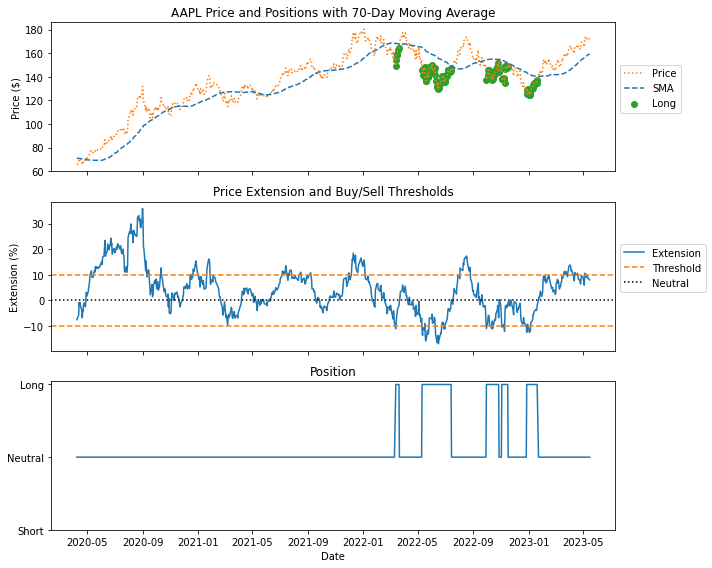

In [18]:
apple_70 = SMAMeanReversionSafety(apple, 70, threshold = 0.1 ,safety_threshold = 0.2)
SMA_plot(apple_70, SMA = 70)

In [34]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [42]:
candlestick = go.Candlestick(
    x=apple_70.index,
    open=apple_70['Open'],
    high=apple_70['High'],
    low=apple_70['Low'],
    close=apple_70['Close'])

# Create a candlestick figure   
fig = go.Figure(data=[candlestick])
fig.update_layout(title='APPL prices')                        
# Show the plot
fig.show()

In [52]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=apple_70.index, y=apple_70['Close'], name="APPL Close Price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=apple_70.index, y=apple_70['SMA'], name="APPL 70-SMA"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=apple_70.index, y=apple_70['position'], name="Take Position"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Double Y Axis Example"
)

# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()